## Try a simplist vae on midi data

In [1]:
import os
import pretty_midi
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import pygame
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

pygame 2.6.1 (SDL 2.28.4, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# load data
path = "../../dataset/midi_dataset/filtered_midi_imgs_small.npy"
# path = "../../dataset/quickdraw_dataset/The The Great Wall_100.npy"
midi_data = np.load(path, allow_pickle=True,)
print(f"Loaded {len(midi_data)} midi files from {path}")
print(f"Shape of midi data: {midi_data.shape}")



Loaded 100000 midi files from ../../dataset/midi_dataset/filtered_midi_imgs_small.npy
Shape of midi data: (100000, 100, 100)


Batch shape: torch.Size([256, 100, 100])


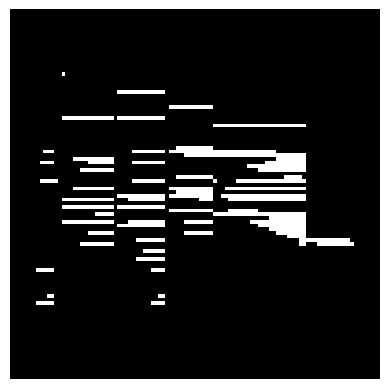

In [3]:
# make dataset 
import torch
from torch.utils.data import Dataset, DataLoader

picked_num = 100000
picked_midi = midi_data[:picked_num]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MidiDataset(Dataset):
    def __init__(self, midi_data):
        self.midi_data = midi_data

    def __len__(self):
        return len(self.midi_data)

    def __getitem__(self, idx):
        midi_file = self.midi_data[idx]
        return midi_file
# Create a dataset and dataloader
midi_dataset = MidiDataset(picked_midi)
midi_dataloader = DataLoader(midi_dataset, batch_size=256, shuffle=True)
# Check the shape of the data
for batch in midi_dataloader:
    print(f"Batch shape: {batch.shape}")
    break
# Visualize the data
def visualize_midi(midi_file):
    plt.imshow(midi_file, cmap='gray')
    plt.axis('off')
    plt.show()
# Visualize a random midi file
random_idx = random.randint(0, len(midi_data) - 1)
midi_file = midi_data[random_idx]
visualize_midi(midi_file)


In [4]:

# write a simplest vae model
from torch import nn
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, latent_dim * 2)  # output mean and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def compute_loss(recon_x, x, mu, logvar, beta=1):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD* beta, BCE, KLD

In [8]:
def train(model, dataloader, optimizer, epochs=10, beta = 1):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch in dataloader:
            batch = (batch.view(batch.size(0), -1).float()/255).to(device)
            # print(f"min batch: {batch.min()}, max batch: {batch.max()}")
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss, bce, kld = compute_loss(recon_batch, batch, mu, logvar, beta)
            loss.backward()
            train_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
            optimizer.step()
        if epoch % 1 == 0:
            print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}, \
                  BCE: {bce_loss / len(dataloader.dataset)}, KLD: {kld_loss / len(dataloader.dataset)}")
        # print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}")

In [23]:
input_dim = 100 * 100  # Assuming the input is a flattened 100x100 image
hidden_dim = 2048
latent_dim = 256

model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
train(model, midi_dataloader, optimizer, epochs=50, beta = 1)
# save the model

model_path = "simpest_vae_model_midi.pth"
torch.save(model.state_dict(), model_path)

Epoch 1, Loss: 1036.561661875,                   BCE: 1005.9601096875, KLD: 30.60154958496094
Epoch 2, Loss: 1034.8773859375,                   BCE: 1004.17405515625, KLD: 30.70333031738281
Epoch 3, Loss: 1033.21664640625,                   BCE: 1002.3750659375, KLD: 30.841581611328124
Epoch 4, Loss: 1031.6664178125,                   BCE: 1000.75676296875, KLD: 30.909655102539062
Epoch 5, Loss: 1030.4600384375,                   BCE: 999.45175796875, KLD: 31.00828119140625
Epoch 6, Loss: 1028.25077234375,                   BCE: 997.12100515625, KLD: 31.129767900390625
Epoch 7, Loss: 1027.077586875,                   BCE: 995.884716875, KLD: 31.192869794921876
Epoch 8, Loss: 1025.056485625,                   BCE: 993.75747578125, KLD: 31.299008720703124
Epoch 9, Loss: 1024.358923125,                   BCE: 993.00601234375, KLD: 31.352911708984376
Epoch 10, Loss: 1022.91698328125,                   BCE: 991.52210484375, KLD: 31.394879482421874
Epoch 11, Loss: 1021.27715609375,          

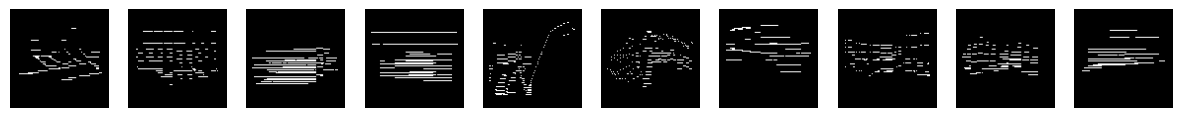

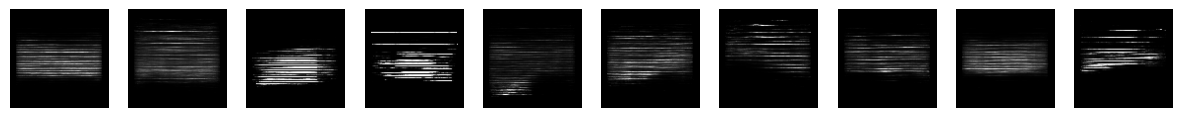

In [22]:
# reconstruct some images
def reconstruct_images(model, dataloader, num_images=10):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = (batch.view(batch.size(0), -1).float()/255).to(device)
            recon_batch, mu, logvar = model(batch)
            recon_batch = recon_batch.view(-1, 1, 100, 100).cpu().numpy()
            break
    return recon_batch[:num_images], batch[:num_images].view(-1, 1, 100, 100).cpu().numpy()
# Visualize the reconstructed images
def visualize_reconstructed_images(recon_images):
    fig, axes = plt.subplots(1, len(recon_images), figsize=(15, 5))
    for i, img in enumerate(recon_images):
        axes[i].imshow(img[0], cmap='gray')
        axes[i].axis('off')
    plt.show()
recon_images, ori_images = reconstruct_images(model, midi_dataloader, num_images=10)
visualize_reconstructed_images(ori_images)
visualize_reconstructed_images(recon_images)


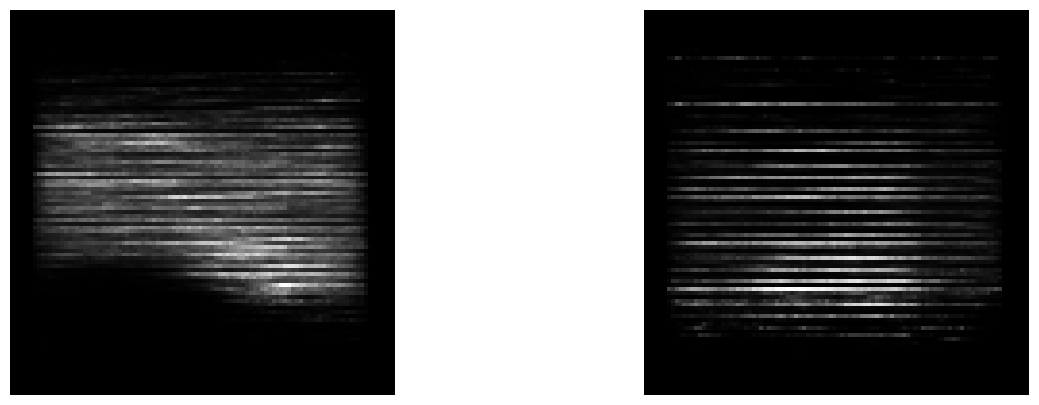

In [15]:
# sample from the model
def generate_sample(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device) 
        samples = model.decode(z).cpu()
        return samples
    
# visualize the samples
def visualize_samples(samples):
    samples = samples.view(-1, 100, 100)  # Reshape to original dimensions
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
    for i, sample in enumerate(samples):
        axes[i].imshow(sample.cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show() 
    
visualize_samples(generate_sample(model, num_samples=2))

Saved sample_0.mid
Saved sample_1.mid
Saved sample_2.mid
Saved sample_3.mid
Saved sample_4.mid
Saved sample_5.mid
Saved sample_6.mid
Saved sample_7.mid
Saved sample_8.mid
Saved sample_9.mid


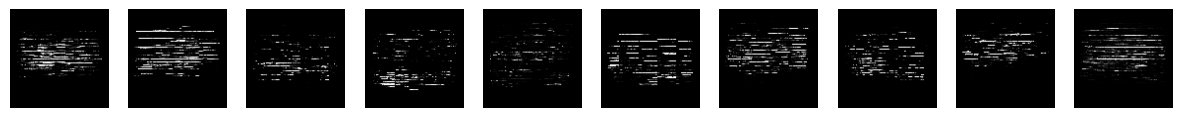

In [10]:
from midi2img import img2midi

samples = generate_sample(model, num_samples=10)
for i, sample in enumerate(samples):
    sample = sample.view(100, 100).cpu().numpy()
    midi_file = img2midi(sample)
    midi_file.write(f"sample_{i}.mid")
    print(f"Saved sample_{i}.mid")
    
visualize_samples(samples)
